# Brain Tumor Classification project

This brain tumor dataset containing 3064 images from 233 patients with three kinds of brain tumor: meningioma (708 slices), glioma (1426 slices), and pituitary tumor (930 slices). Due to the file size limit of repository, we split the whole dataset into 4 subsets, and achive 
them in 4 .zip files with each .zip file containing 766 slices.

The objective of this project is to build a classifier to classify each type of tumor.

In [1]:
# Imports
import random
import zipfile
import io
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sb


from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [2]:
# Constants
FOLDERS = [
    './BrainTumorDataPublic-1.zip',
    './BrainTumorDataPublic-2.zip',
    './BrainTumorDataPublic-3.zip',
    './BrainTumorDataPublic-4.zip'
]

IMAGE_SHAPE = (512, 512)

LABELS_NAME = {
    1 : "Meningioma",
    2 : "Glioma",
    3 : "Pituitary"
}

MAX_ZIP_SIZE = 1e8

In [3]:
# Functions
def show_image(images: np.array, labels: np.array, border: list, names: dict = LABELS_NAME) -> None:
    """
    This function take the a random image from the 
    the array that contains images, and plot it,
    with as title the class label of the image. Add
    also the border of the tumor.
    """
    # Get a random index
    idx = random.randint(0, len(images))

    # Get the delimitation tumor
    obj = border[idx]

    # Get x and y axis
    x_axis = obj[0, 1::2]
    y_axis = obj[0, ::2]
    
    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx], cmap='gray')
    plt.plot(x_axis, y_axis, ls='--', c='y', lw=3)
    plt.title(f"Class: {names[labels[idx]]}")
    plt.axis('off')
    plt.show()

def compare_images(images: np.array, images_recovered: np.array, labels: np.array, names: dict = LABELS_NAME) -> None:
    """
    This function take the a random image from the 
    the array that contains recovered after PCA, 
    and the array that contains images, reshape it
    and plot both with as title the class label of 
    the images.
    """
    # Get a random index
    idx = random.randint(0, len(images))

    # Plot
    plt.figure(figsize=(12,12))
    plt.subplot(1, 2, 1)
    plt.imshow(images[idx, :].reshape(IMAGE_SHAPE), cmap='gray')
    plt.title(f"Original \n Class: {names[labels[idx]]}")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(images_recovered[idx, :].reshape(IMAGE_SHAPE), cmap='gray')
    plt.title(f"Compressed \n Class: {names[labels[idx]]}")
    plt.axis('off')
    plt.show()

def show_knn_prediction(images: np.array, labels: np.array, classifier: KNeighborsClassifier) -> None:
    """
    This function take the array that contains all images 
    reduced after PCA and LDA, the class labels and a classifier
    (KNN). It plots in 2D each data points and the classification
    area.
    """
    # Get the epsilon to color arround the data points
    eps = images.std() / 2                                                                                                       

    # Get minimum and maximum of x and y axis                                                                                                   
    x_min, x_max = images[:, 0].min() - eps, images[:, 0].max() + eps                                                                      
    y_min, y_max = images[:, 1].min() - eps, images[:, 1].max() + eps 

    # Create x and y axis space                                                                     
    x_space = np.linspace(x_min, x_max, 1000)                                                                                         
    y_space = np.linspace(y_min, y_max, 1000)                                                                                         

    # Create grid
    grid1, grid2 = np.meshgrid(x_space, y_space)                                                                                                 
    x_grid = np.c_[grid1.ravel(), grid2.ravel()]   

    # Prediction                                                                                    
    decision_values = classifier.predict(x_grid)

    # Plot
    plt.figure(figsize=(10, 5))                                                                                 
    plt.imshow(
        decision_values.reshape(grid1.shape), 
        extent=(x_min, x_max, y_min, y_max),
        aspect='auto', 
        origin='lower', 
        alpha=0.3
    )
    plt.scatter(images[:, 0], images[:, 1], c=labels, alpha=0.7)
    plt.show() 

def predict_image(images: np.array, labels: np.array, prediction: np.array) -> None:
    """
    This function take the a random image from the 
    the array that contains test images, reshape it 
    and plot it, with as title the predicted value 
    of the image.
    """
    # Get a random index
    idx = random.randint(0, len(images))
                   
    # Plot a random image
    plt.figure(figsize=(6,6))
    plt.imshow(images[idx],  cmap='gray')
    plt.title(f"True class: {labels[idx]} \n Predicted class: {prediction[idx]}")
    plt.axis('off')
    plt.show()

### Data loading

In [4]:
# Create a new folder to store the data
newpath = './Data'
if not os.path.exists(newpath):
    os.makedirs(newpath)

# Define an increment for naming zip file
zip_num = 1
# Instantiate a zip file
zip_file = zipfile.ZipFile(f"{newpath}/BrainTumorData-{zip_num}.zip", mode='w')

for file in FOLDERS:
    # Read zip file (without unzip it)
    with zipfile.ZipFile(file, 'r') as zip_ref:
        for mat_file in zip_ref.namelist():
            # Check if the zip file does not exceed the GitHub maximum size
            if os.path.getsize(f"{newpath}/BrainTumorData-{zip_num}.zip") > MAX_ZIP_SIZE:
                # Close the current zip file
                zip_file.close()
                # Create a new one
                zip_num += 1
                zip_file = zipfile.ZipFile(f"{newpath}/BrainTumorData-{zip_num}.zip", mode='w')
            
            # Extract the .mat file in the current directory
            zip_ref.extract(mat_file)
            # Add it to the new zip file
            zip_file.write(mat_file)
            # Remove the .mat file from the current directory
            os.remove(mat_file)

# Finally close the last new zip file
zip_file.close()

In [5]:
# Define a list to store the image, label, and border arrays 
image_list, label_list, border_list  = [[] for _ in range(3)]
zip_folders = [folder for folder in os.listdir('.') if folder.endswith('.zip')]

for folder in zip_folders: 
    # Read zip file (without unzip it)
    with zipfile.ZipFile(folder, 'r') as zip_ref:
        # Get the list of .mat file in the zip folder
        mat_files = zip_ref.namelist()

        # Get the number of images
        num_files = len(mat_files)
        
        # Make a for loop
        for image in mat_files:
            # Open the first file in the zip folder
            with zip_ref.open(image) as image_bytes:
                
                # Load the .mat file using h5py
                with h5py.File(io.BytesIO(image_bytes.read()), 'r') as image_h5:
                    
                    # Get a dictionary of all the data in the file structure
                    data = image_h5['cjdata']

                    # Get the image, label and border and save in h5 object
                    data_img = data['image']
                    data_label = data['label']
                    data_broder = data['tumorBorder']

                    # Store h5 content in numpy arrays
                    img = np.array(data_img[:], dtype=np.uint8)
                    label = np.array(data_label[:], dtype=np.uint8)
                    border = np.array(data_broder[:], dtype=np.float32)

                    # Resize the img to a standard size
                    img_resized = cv2.resize(img, IMAGE_SHAPE)

                    # Append arrays to storage list
                    image_list.append(img_resized)
                    label_list.append(label)
                    border_list.append(border)

# Assertion on list length
assert len(image_list) == len(label_list) == len(border_list)

In [6]:
# Concatenate the list of images into a single numpy array
images = np.stack(image_list)
# Convert the labels list to a numpy array
labels = np.array(label_list).reshape(-1)

print(f"Image shape: {images.shape}")
print(f"Label shape: {labels.shape}")

Image shape: (3064, 512, 512)
Label shape: (3064,)


In [7]:
# Create X and y array to use classical ML algorithm
# Flatten the data first
X = images.reshape(len(images), -1)
y = labels.copy() # Shallow copy (not an issue here)

print(f"Flatten array shape: {X.shape}")

Flatten array shape: (3064, 262144)


### Eploratory Data Analysis

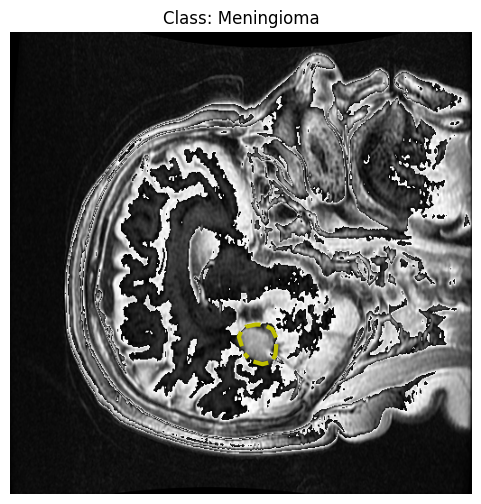

In [12]:
# Plot an image
show_image(images, labels, border_list)

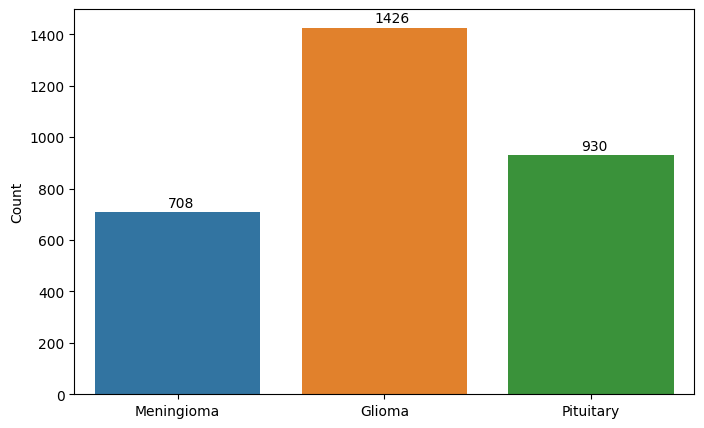

In [10]:
# Repartition of the classes across the dataset
_, counts = np.unique(y, return_counts=True)

# Plot classes counts
plt.figure(figsize=(8, 5))
sb.barplot(x=list(LABELS_NAME.values()), y=counts)
for i, j in enumerate(counts):
    plt.text(i-0.05, j+20, str(j))
plt.ylabel('Count')
plt.show()

In [9]:
# Verification of pixel gray scale
print(f"Maximum pixel value: {X.max()}")
print(f"Minimum pixel value: {X.min()}")

Maximum pixel value: 255
Minimum pixel value: 0


In [17]:
# Invoking the TSNE method
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

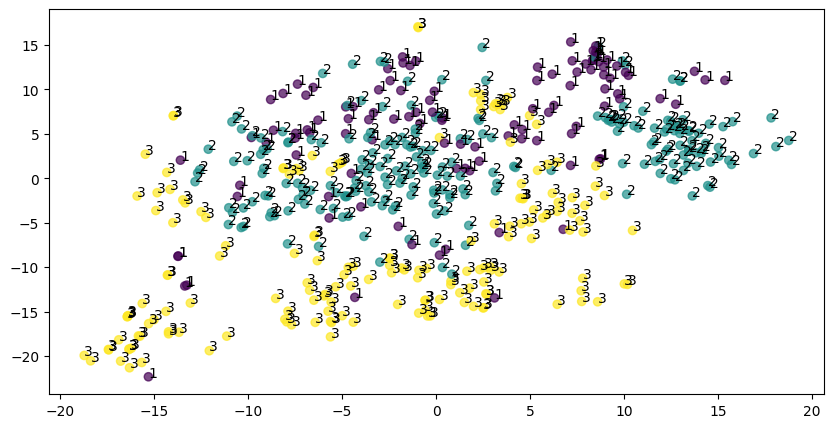

In [29]:
# Generate random sequence
rand_seq = random.sample(range(len(X)), 500)

# Plot the result of TSNE reduction
plt.figure(figsize=(10,5))
plt.scatter(X_tsne[rand_seq, 0], X_tsne[rand_seq, 1], c=y[rand_seq], alpha=0.7)
for i in rand_seq:
    plt.text(X_tsne[i, 0], X_tsne[i, 1], str(y[i]))
plt.show()

### Preprocessing

In [13]:
# Normalization
X = X / 255.0

# Split into train and test set
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Check train an test size
print(f"Training size: {len(y_train)}")
print(f"Testing size: {len(y_test)}")

Training size: 2451
Testing size: 613


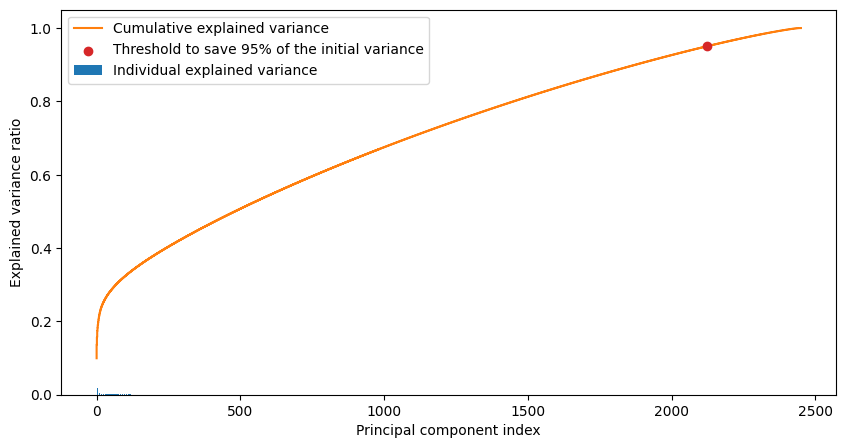

In [20]:
# Dimensionality reduction using PCA
# Detection of the number of component needed
pca = PCA()
pca.fit(X_train)

# Explained variance ratio analysis
exp_var = pca.explained_variance_ratio_
cumsum_exp_var = np.cumsum(exp_var)
n_components = len(exp_var) # Because n_components = min(n_samples, n_features)

# Plot only the 500 first components
plt.figure(figsize=(10,5))
plt.bar(
    range(0, n_components), 
    exp_var, 
    label='Individual explained variance', 
    color='C0'
)
plt.step(
    range(0, n_components), 
    cumsum_exp_var, 
    label='Cumulative explained variance', 
    color='C1'
)
plt.scatter(
    np.argmax(np.cumsum(exp_var) >= 0.95), 
    0.95, 
    label='Threshold to save 95% of the initial variance', 
    c='C3',
    zorder=3
)
plt.xlabel("Principal component index")
plt.ylabel("Explained variance ratio")
plt.legend()
plt.show()

In [15]:
# Define and train PCA with 2048 components (preserved ~95% of the variance)
pca = PCA(n_components=2048, random_state=123)
pca.fit(X_train)

# Transform our train and test data
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

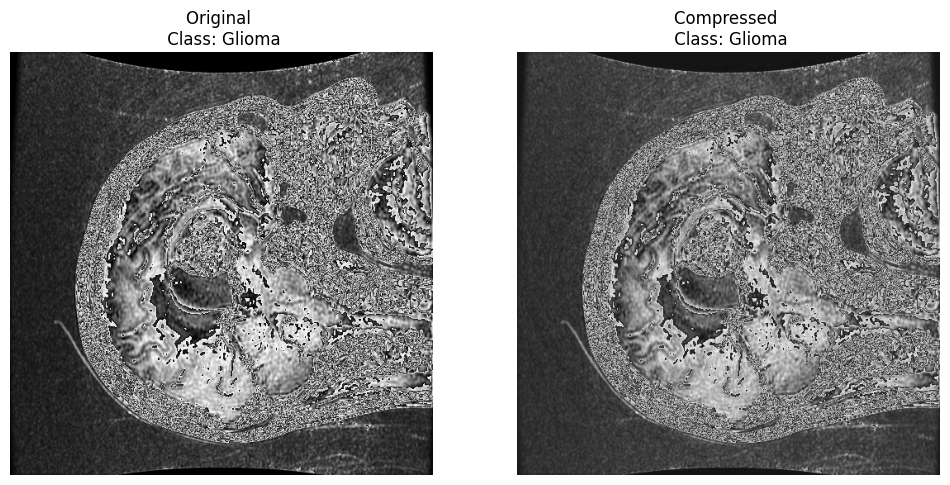

In [16]:
# Get compressed array
X_train_recovered = pca.inverse_transform(X_train_reduced)

compare_images(X_train, X_train_recovered, y_train)

In [49]:
# Save X arrays in npz compressed format
np.savez_compressed('./CompressedArray', train=X_train_reduced, test=X_test_reduced)

In [14]:
# Load the compressed X arrays
loaded = np.load('./CompressedArray.npz')
for i, file in enumerate(loaded.files, start=1):
    print(f"File n°{i}: {file}")

# Assign X train and test
X_train_reduced = loaded['train']
X_test_reduced = loaded['test']

File n°1: train
File n°2: test


### Modeling

In [19]:
# Define the StratifiedKFold
skf = StratifiedKFold(n_splits=5)

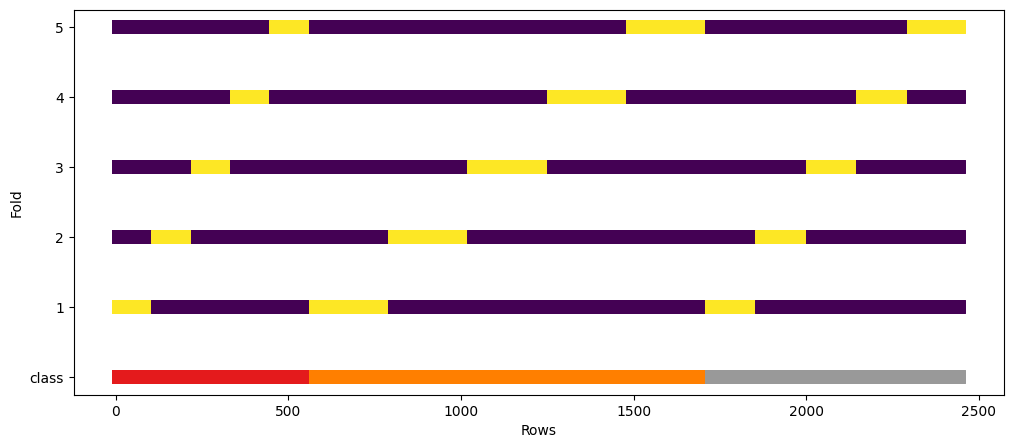

In [78]:
# Visualize the Stratified cross validation
# Sort indices by class
sorted_indices = np.argsort(y_train)

# Sort y_train and X_train by class
y_train_sorted = y_train[sorted_indices]
X_train_sorted = X_train_reduced[sorted_indices]

# Plot
plt.figure(figsize=(12, 5))
for i, (tr_idx, te_idx) in enumerate(skf.split(X_train_sorted, y_train_sorted), start=1):
    # Fill in indices with the training/test groups
    indices = np.zeros(len(X_train_sorted))
    indices[te_idx] = 1 
    
    plt.scatter(
        range(len(indices)), 
        [i] * len(indices),
        c=indices,
        marker="_",
        lw=10
    )
plt.scatter(
    range(len(indices)),
    [0] * len(indices), 
    c=y_train_sorted,
    marker="_", 
    lw=10,
    cmap='Set1'
)
plt.ylabel('Fold')
plt.xlabel('Rows')
# Change the yticks to add class
plt.yticks(ticks=range(6), labels=['class'] + list(range(1,6)))
plt.show()

In [49]:
# Initialize transformer and classifier algorithms
knn = KNeighborsClassifier()
svc = SVC()
lda = LinearDiscriminantAnalysis()
kmeans = KMeans(n_clusters=30, n_init='auto')

In [44]:
# Use stratified cross validation on KNN classifier
result_knn = pd.DataFrame(cross_validate(
    knn,
    X_train_reduced,
    y_train,
    return_train_score=True,
    cv=skf.split(X_train_reduced, y_train),
    scoring=['accuracy']
))

# Get mean train and test accuracy
print(f"Mean train accuracy: {result_knn['train_accuracy'].mean():.3f}")
print(f"Mean validation accuracy: {result_knn['test_accuracy'].mean():.3f}")

Mean train accuracy: 0.681
Mean validation accuracy: 0.641


In [45]:
# Define the pipeline to use KMeans as preprocessing part
pipeline = Pipeline([
    ('kmeans', kmeans),
    ('knn', knn)
])

# Use stratified cross validation on KNN classifier
result_kmeans_knn = pd.DataFrame(cross_validate(
    pipeline,
    X_train_reduced,
    y_train,
    return_train_score=True,
    cv=skf.split(X_train_reduced, y_train),
    scoring=['accuracy']
))

# Get mean train and test accuracy
print(f"Mean train accuracy: {result_kmeans_knn['train_accuracy'].mean():.3f}")
print(f"Mean validation accuracy: {result_kmeans_knn['test_accuracy'].mean():.3f}")

Mean train accuracy: 0.894
Mean validation accuracy: 0.829


In [50]:
# Use stratified cross validation on SVM classifier
result_svc = pd.DataFrame(cross_validate(
    svc,
    X_train_reduced,
    y_train,
    return_train_score=True,
    cv=skf.split(X_train_reduced, y_train),
    scoring=['accuracy']
))

# Get mean train and test accuracy
print(f"Mean train accuracy: {result_svc['train_accuracy'].mean():.3f}")
print(f"Mean validation accuracy: {result_svc['test_accuracy'].mean():.3f}")

Mean train accuracy: 0.991
Mean validation accuracy: 0.863


In [38]:
# LDA dimensionality reduction
lda.fit(X_train_reduced, y_train)
X_train_embedded = lda.transform(X_train_reduced)

# Use stratified cross validation to avoid overfitting on LDA classifier
result_lda_knn = pd.DataFrame(cross_validate(
    knn,
    X_train_embedded,
    y_train,
    return_train_score=True,
    cv=skf.split(X_train_reduced, y_train),
    scoring=['accuracy']
))

# Get mean train and test accuracy
print(f"Mean train accuracy: {result_lda_knn['train_accuracy'].mean():.3f}")
print(f"Mean test accuracy: {result_lda_knn['test_accuracy'].mean():.3f}")

Mean train accuracy: 0.997
Mean test accuracy: 0.996


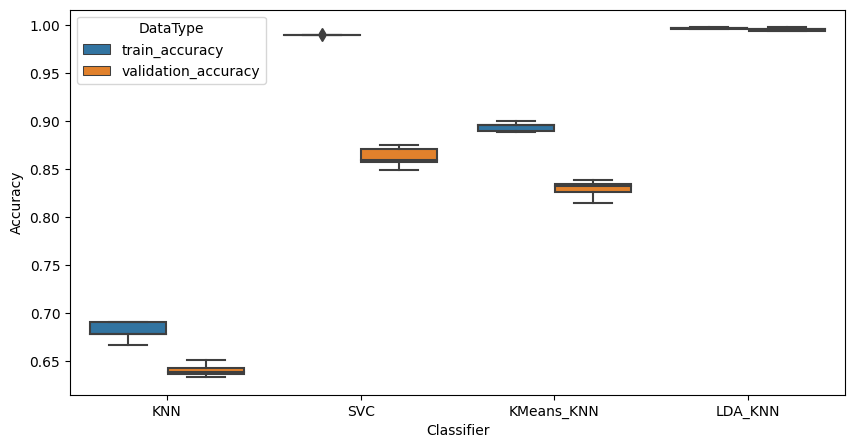

In [51]:
# Comparison of result
# Create a dataframe by concatenating results
result = pd.concat([result_knn, result_svc, result_kmeans_knn, result_lda_knn])

# Add classifiers columns
result['Classifier'] = ["KNN"]*5 + ["SVC"]*5 + ["KMeans_KNN"]*5 + ["LDA_KNN"]*5
# Rename validation score
result.rename(columns={'test_accuracy' : 'validation_accuracy'}, inplace=True)

# Melt the dataframe
result = pd.melt(
    result, 
    id_vars=['Classifier'], 
    value_vars=['train_accuracy', 'validation_accuracy'], 
    var_name='DataType', 
    value_name='Accuracy'
)

# Plot the result
plt.figure(figsize=(10, 5))
sb.boxplot(data=result, x='Classifier', y='Accuracy', hue='DataType')
plt.show()

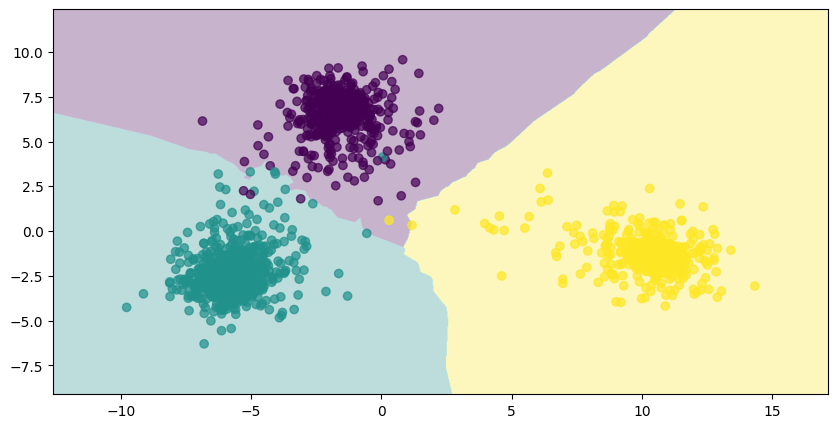

In [52]:
# Fit KNN classifier 
knn.fit(X_train_embedded, y_train)
# Shot prediction boundary
show_knn_prediction(X_train_embedded, y_train, knn)

In [140]:
# LDA on test set
X_test_embedded = lda.transform(X_test_reduced)
# KNN prediction
y_pred = knn.predict(X_test_embedded)

print(f"Accuracy on test set: {accuracy_score(y_test, y_pred):.3f}")

Accuracy on test set: 0.899


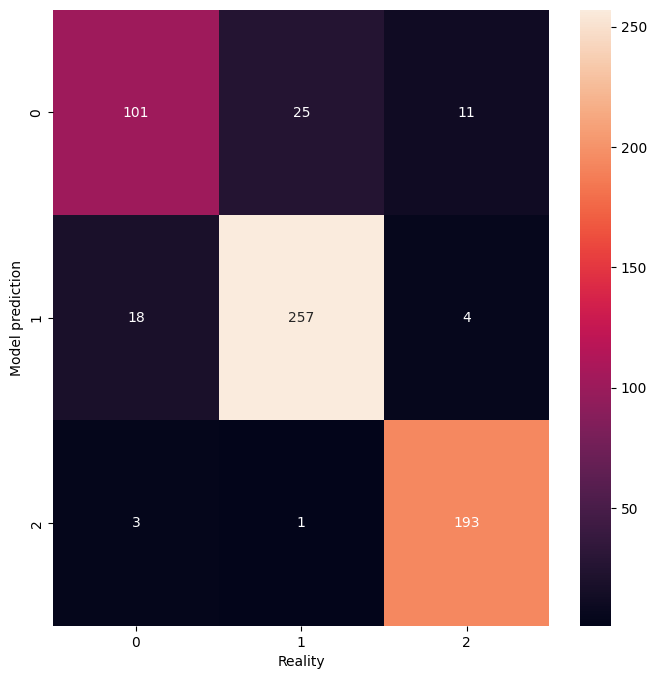

In [141]:
# Confusion matrix
plt.figure(figsize=(8,8))
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt = 'g')
plt.xlabel("Reality")
plt.ylabel("Model prediction")
plt.show()